# Traffic sign classification

## Download data

In [1]:
!git clone https://github.com/iramamy/Trafficsign.git

Cloning into 'Trafficsign'...
remote: Enumerating objects: 51887, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 51887 (delta 0), reused 3 (delta 0), pack-reused 51883
Receiving objects: 100% (51887/51887), 299.43 MiB | 47.59 MiB/s, done.
Updating files: 100% (51842/51842), done.


## Import packages

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight

# Deeplearning libraries
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D 

## Visualize our dataset

In [4]:
HOME = os.getcwd()

### Method to visualize sample image

In [5]:
def visualize_image(folder_name):
    path = f"{HOME}/Trafficsign/Data/{folder_name}"
    plt.figure(figsize=(12, 12))
    for i in range(1, 11):
        plt.subplot(2, 5, i)
        img = imread(path+'/'+random.choice(sorted(os.listdir(path))))
        plt.imshow(img)
        plt.axis('off')

    plt.subplots_adjust(hspace=-0.75)
        

#### Visualize data in test folder

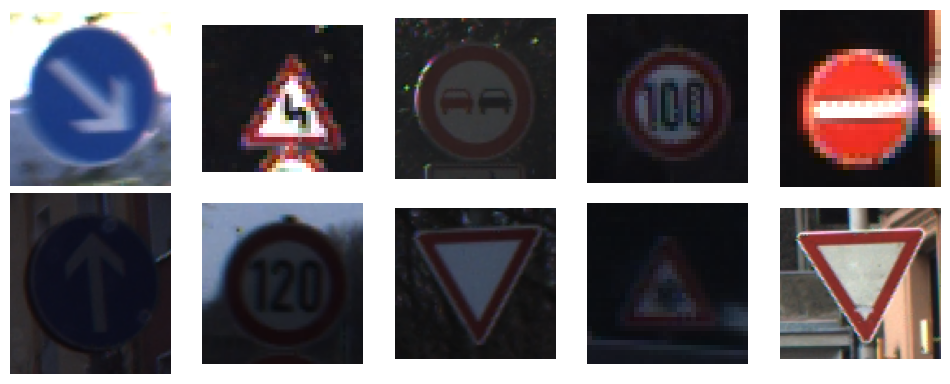

In [6]:
visualize_image('Test')

In [7]:
path_train = f'{HOME}/Trafficsign/Data/Train'
N_CLASSES = len(next(os.walk(path_train))[1])

### Resize images

In [8]:
dim1, dim2 = [], []
for i in range(N_CLASSES):
    labels = path_train+'/{0}'.format(i)
    img_path = os.listdir(labels)
    for path in img_path:
        img = imread(labels+'/'+path)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])        

### Store the mean dimension value of all images

In [9]:
x = np.mean(dim1)
y = np.mean(dim2)

In [10]:
def scale_image(folder_path, is_test=False):
    images = []
    label_id = []
    
    if is_test:
        filenames = sorted(os.listdir(folder_path))
        for filename in filenames:
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            img = img.resize((int(x), int(y)))
            img = np.array(img)/255
            images.append(img)
            label_id.append(1)
    else:
        for i in range(N_CLASSES):
            labels = folder_path+'/{0}'.format(i)
            img_path = os.listdir(labels)

            for path in img_path:
                img = Image.open(labels+'/'+path)
                img = img.resize((int(x), int(y)))
                img = np.array(img)/255
                images.append(img)
                label_id.append(i)

    return images, label_id

### Convert into numpy array

In [11]:
images, label_id = scale_image(path_train)
images = np.array(images)
label_id = np.array(label_id)

## Class distribution

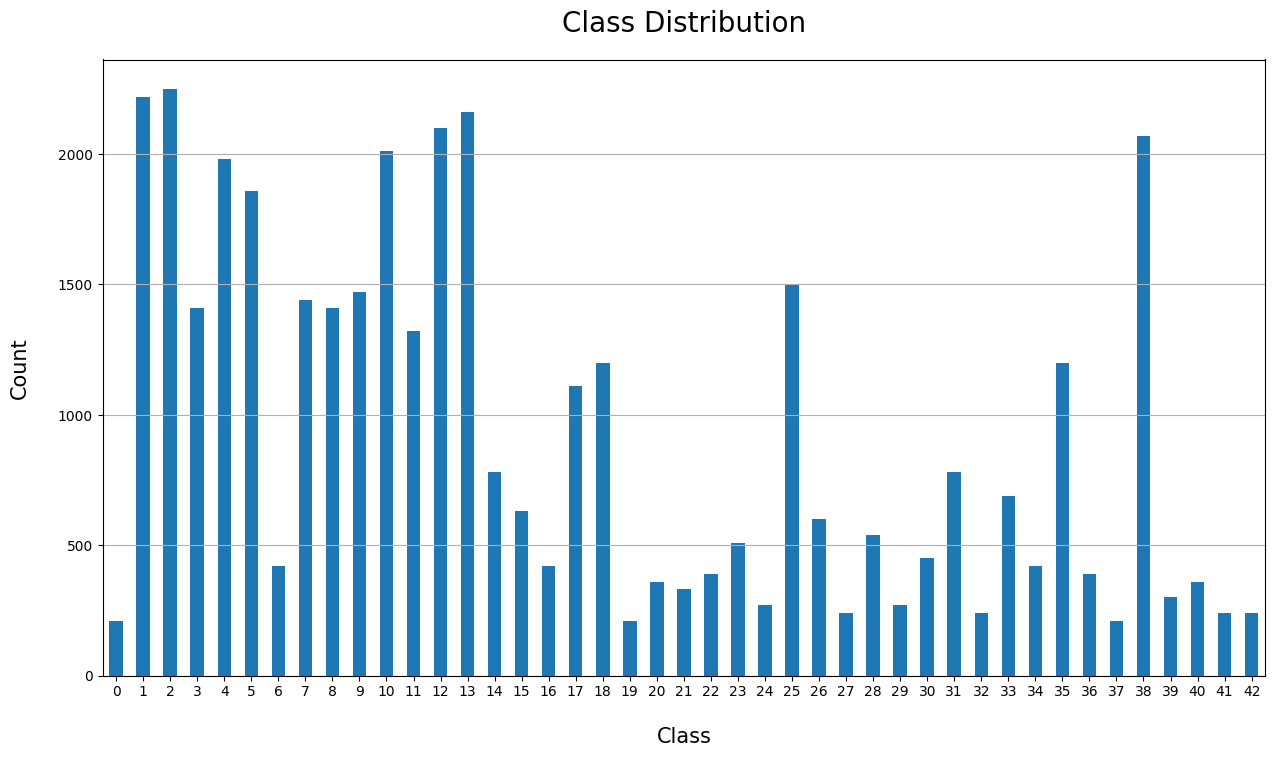

In [29]:
class_count = pd.DataFrame(label_id).value_counts().sort_index()
class_count = class_count.reset_index(drop=True)

# Plotting the bar chart
plt.figure(figsize=(15, 8))
class_count.plot(kind='bar')
plt.xlabel('Class', fontsize=15, labelpad=20)
plt.ylabel('Count', fontsize=15, labelpad=20)
plt.title('Class Distribution', fontsize=20, pad=20)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.savefig('class_distribution.jpg', dpi=300)
# Show the plot
plt.show()

In [13]:
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(label_id),
    y=label_id)

class_weights = {}
for i, weight in enumerate(weights):
    class_weights[i] = weight

## Split data

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    images, label_id, test_size=0.2, random_state=42
)

## Encode label

In [15]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

## Create model

In [17]:
INPUT_SHAPE = X_train.shape[1:]

model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(N_CLASSES, activation='softmax'))

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 23, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041,131 (3.97 MB)

 Trainable params: 1,041,131 (3.97 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_val, y_val),
     class_weight=class_weights
)

Epoch 1/15
 18/491 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0279 - loss: 3.7756   

I0000 00:00:1720017539.674251     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720017539.693226     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1448 - loss: 3.1818

W0000 00:00:1720017550.893651     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


491/491 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.1451 - loss: 3.1804 - val_accuracy: 0.6682 - val_loss: 1.1024
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5993 - loss: 1.1748 - val_accuracy: 0.8509 - val_loss: 0.5902
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7415 - loss: 0.6946 - val_accuracy: 0.9009 - val_loss: 0.3493
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8101 - loss: 0.4843 - val_accuracy: 0.9342 - val_loss: 0.2628
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8410 - loss: 0.3915 - val_accuracy: 0.9556 - val_loss: 0.1891
Epoch 6/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8759 - loss: 0.3064 - val_accuracy: 0.9572 - val_loss: 0.1646
Epoch 7/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8869 - loss: 0.2867 - val_accuracy: 0.9654 - val_loss: 0.1318
Epoch 8/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9014 - loss: 0.2461 - val_accuracy: 0.9707 - va

In [30]:
def plot_history(history):
    hist = history.history
    plt.subplots(1,2,figsize=(16,8))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(range(len(hist['loss'])), hist['loss'], label='Train')
    plt.plot(range(len(hist['val_loss'])), hist['val_loss'], label='Validation')
    plt.xlabel('Epochs', fontsize=16, labelpad=20)
    plt.ylabel('Loss', fontsize=16, labelpad=20)
    plt.legend()
    plt.title('Loss Over Epochs', fontsize=20, pad=20)

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(range(len(hist['accuracy'])), hist['accuracy'], label='Train')
    plt.plot(range(len(hist['val_accuracy'])), hist['val_accuracy'], label='Validation')
    plt.xlabel('Epochs', fontsize=16, labelpad=20)
    plt.ylabel('Accuracy', fontsize=16, labelpad=20)
    plt.legend()
    plt.title('Accuracy Over Epochs', fontsize=20, pad=20)
    plt.savefig('model_history.jpg', dpi=300)

    plt.show()       

## Training history

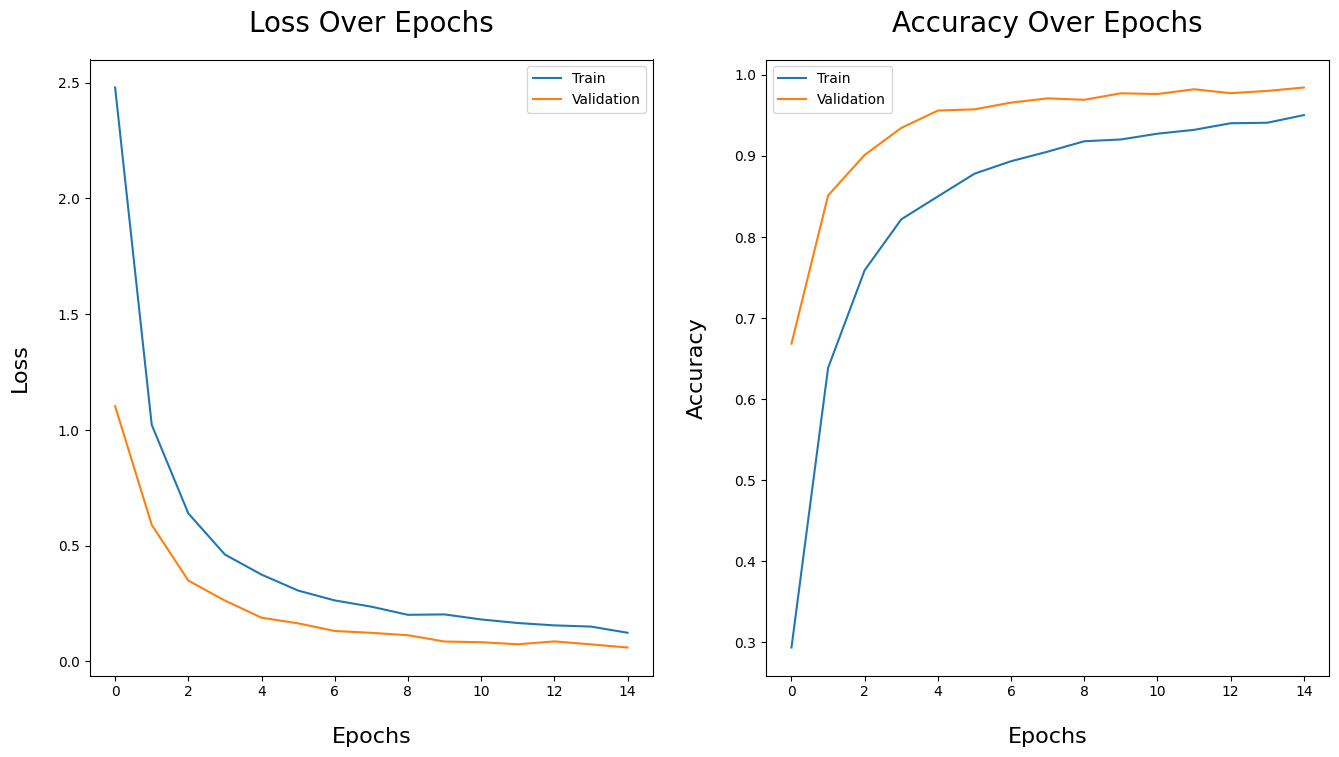

In [31]:
plot_history(history)

# Scale and normalize test images

In [22]:
path_test = f'{HOME}/Trafficsign/Data/Test'
test_images, _ = scale_image(path_test, is_test=True)
test_images = np.array(test_images)

## Make prediction

In [24]:
predicted_label = model.predict(test_images)
predicted_label = np.argmax(predicted_label, axis=-1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [27]:
true_label = pd.read_csv(f'{HOME}/Trafficsign/Data/Test.csv')
true_label = true_label["ClassId"].values

In [28]:
print(accuracy_score(predicted_label, true_label))

0.9433095803642122
